 ## Analysis of Cable Production Failures Dataset ## 

### 1. Setup and Import Libraries ###

In [2]:
# Load necessary libraries
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copulas
from scipy import stats
from scipy.stats import t, norm, chi2
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d
import pandas as pd

### 2. Load and Prepare the Data ###

In [3]:
# Load and prepare data
data=pd.read_csv( "Research_project/Data/Cable-Production-Line-Dataset.csv")
data
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
# Display the first few rows
print(data.head())

   Machine Shift  Operator       Date  Cable Failures  Cable Failure Downtime  \
0        1     A         1 2020-11-06               1                      35   
1        2     A         2 2020-11-06               1                      10   
2        2     B         3 2020-11-06               2                      40   
3        2     A         2 2020-11-07               5                     120   
4        2     B         3 2020-11-07               2                      40   

   Other Failures  Other Failure Downtime  
0               1                      30  
1               3                     150  
2               2                     110  
3               1                      80  
4               1                      35  


### Checking Dependencies among variables 

In [4]:

# Columns of interest

columns = ['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']

# Subset data for the columns of interest
data_subset = data[columns]

# Calculate Spearman's rho correlation matrix
spearman_corr = data_subset.corr(method='spearman')
print("Spearman's rho correlation matrix:")
print(spearman_corr)

# Calculate Kendall's tau correlation matrix
kendall_corr = data_subset.corr(method='kendall')
print("\nKendall's tau correlation matrix:")
print(kendall_corr)


Spearman's rho correlation matrix:
                        Cable Failures  Cable Failure Downtime  \
Cable Failures                1.000000                0.874905   
Cable Failure Downtime        0.874905                1.000000   
Other Failures               -0.445305               -0.463634   
Other Failure Downtime       -0.453950               -0.456626   

                        Other Failures  Other Failure Downtime  
Cable Failures               -0.445305               -0.453950  
Cable Failure Downtime       -0.463634               -0.456626  
Other Failures                1.000000                0.964078  
Other Failure Downtime        0.964078                1.000000  

Kendall's tau correlation matrix:
                        Cable Failures  Cable Failure Downtime  \
Cable Failures                1.000000                0.767810   
Cable Failure Downtime        0.767810                1.000000   
Other Failures               -0.390310               -0.380140   
Other Fail

### 3. Exploratory Data Analysis (EDA) ###

In [5]:
#a. Summary Statistics
print(data.describe())


          Machine    Operator  Cable Failures  Cable Failure Downtime  \
count  149.000000  149.000000      149.000000              149.000000   
mean     5.932886   12.946309        1.409396               51.442953   
std      4.294346    8.659306        1.325495               56.658935   
min      1.000000    1.000000        0.000000                0.000000   
25%      2.000000    6.000000        0.000000                0.000000   
50%      5.000000   12.000000        1.000000               35.000000   
75%      8.000000   18.000000        2.000000               70.000000   
max     17.000000   32.000000        6.000000              295.000000   

       Other Failures  Other Failure Downtime  
count      149.000000               149.00000  
mean         0.536913                47.04698  
std          0.969281               106.39678  
min          0.000000                 0.00000  
25%          0.000000                 0.00000  
50%          0.000000                 0.00000  
75%   

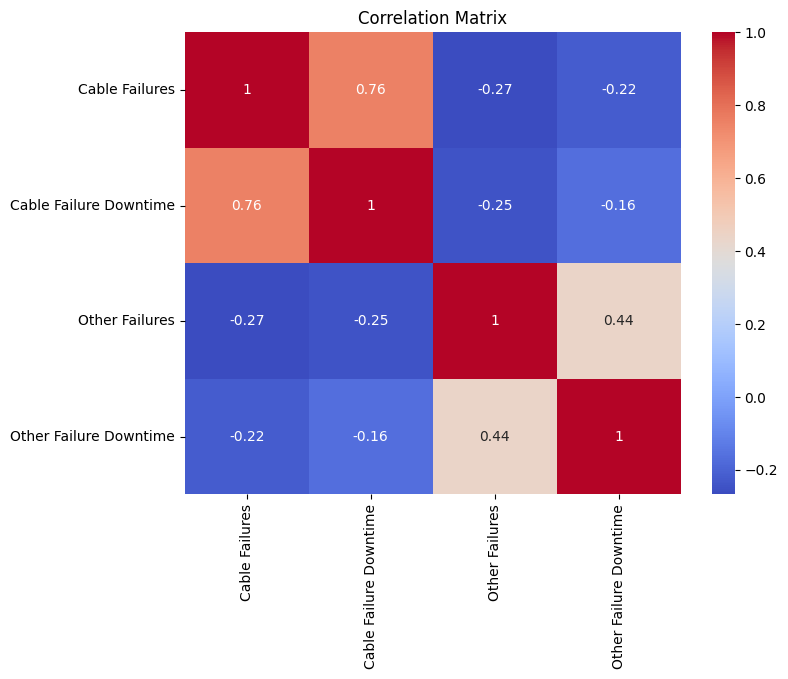

In [6]:
#b. Correlation Analysis
# Select numerical columns
numeric_cols = ['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']

# Compute correlation matrix
corr_matrix = data[numeric_cols].corr()


# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


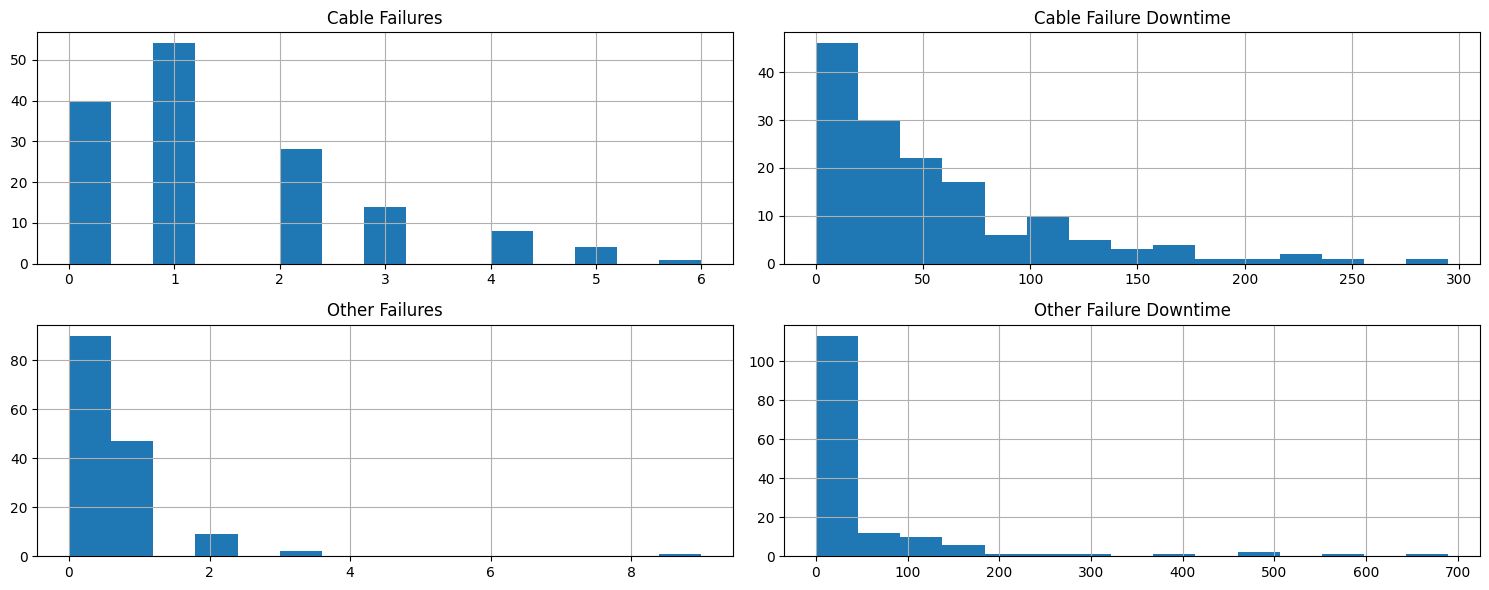

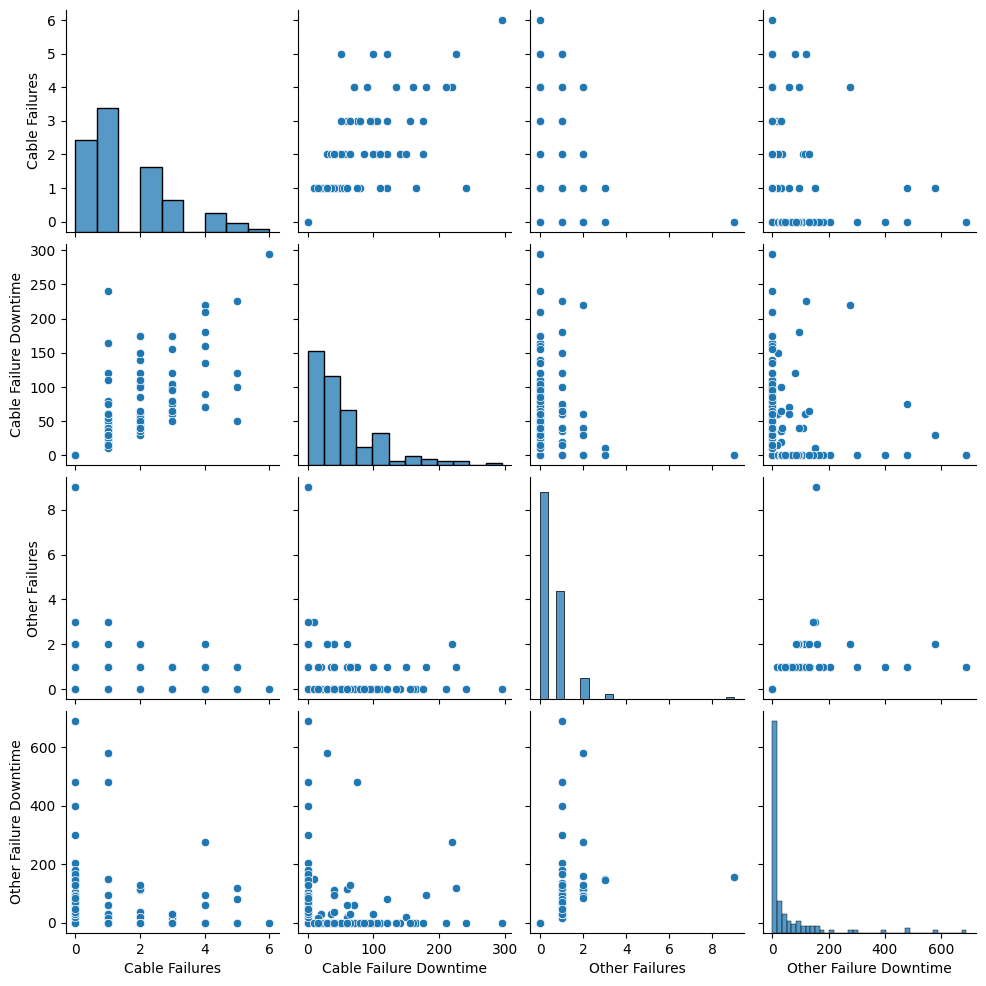

In [7]:
#c. Visualizations
# Histograms
data[numeric_cols].hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(data[numeric_cols])
plt.show()


### Fitting suitable distribution to the data 

In [8]:


# Columns of interest
columns = ['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']

# Function to calculate the goodness of fit for a given distribution
def calculate_gof(distribution, data):
    params = distribution.fit(data)
    ks_stat, ks_p_value = stats.kstest(data, distribution.name, args=params)
    return ks_stat, ks_p_value

# Function to find the best fitting distribution
def find_best_distribution(data, column_name):
    distributions = [stats.gamma, stats.norm, stats.expon, stats.lognorm, stats.beta, stats.uniform, stats.chi2, stats.weibull_min, stats.t]
    best_fit = None
    best_ks_stat = np.inf
    best_dist_name = None
    
    for distribution in distributions:
        try:
            ks_stat, ks_p_value = calculate_gof(distribution, data)
            print(f"{distribution.name}: KS Statistic = {ks_stat}, p-value = {ks_p_value}")
            if ks_stat < best_ks_stat:
                best_ks_stat = ks_stat
                best_dist_name = distribution.name
                best_fit = distribution.fit(data)
        except Exception as e:
            print(f"Could not fit {distribution.name} to {column_name}: {e}")
    
    print(f"\nBest fitting distribution for {column_name}: {best_dist_name} with KS Statistic = {best_ks_stat}")
    return best_dist_name, best_fit

# Loop over each column and find the best fitting distribution
best_fits = {}
for column in columns:
    data_column = data[column].dropna()  # Ensure to drop NaN values
    best_fits[column] = find_best_distribution(data_column, column)

# Print the best fitting distributions
print("\nBest fitting distributions for each variable:")
for column, (dist_name, params) in best_fits.items():
    if dist_name:
        print(f"{column}: {dist_name} with parameters {params}")
    else:
        print(f"{column}: No fitting result due to an error.")


gamma: KS Statistic = 0.4652389691908185, p-value = 4.5788834954467686e-30
norm: KS Statistic = 0.25255561813464295, p-value = 7.296982247525479e-09
expon: KS Statistic = 0.2684563758389262, p-value = 5.669612292706346e-10
lognorm: KS Statistic = 0.4049081450977753, p-value = 1.3953381238900818e-22
beta: KS Statistic = 0.350834247860299, p-value = 6.675946846085676e-17
uniform: KS Statistic = 0.48545861297539156, p-value = 7.29694395859227e-33


C:\Users\ratne\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


chi2: KS Statistic = 0.5281456858078319, p-value = 2.7780333654754078e-39
weibull_min: KS Statistic = 0.2910476059352413, p-value = 1.1284906504469278e-11
t: KS Statistic = 0.21411487110589283, p-value = 1.7866121248363897e-06

Best fitting distribution for Cable Failures: t with KS Statistic = 0.21411487110589283
gamma: KS Statistic = 0.2684563758389262, p-value = 5.669612292706346e-10
norm: KS Statistic = 0.18114692176662406, p-value = 9.466843112474476e-05
expon: KS Statistic = 0.2684563758389262, p-value = 5.669612292706346e-10
lognorm: KS Statistic = 0.32624949303419204, p-value = 1.2713005022280599e-14
beta: KS Statistic = 0.2684563758389261, p-value = 5.6696122927064e-10
uniform: KS Statistic = 0.5246274599021727, p-value = 1.0004702909090994e-38
chi2: KS Statistic = 0.34586463373433407, p-value = 1.9964341291943658e-16
weibull_min: KS Statistic = 0.2799636448199019, p-value = 8.044481793014343e-11
t: KS Statistic = 0.7014869481471873, p-value = 4.4449791875320644e-74

Best fitt

C:\Users\ratne\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


chi2: KS Statistic = 0.6040268456375839, p-value = 1.3503546492811488e-52
weibull_min: KS Statistic = 0.6040268456375839, p-value = 1.3503546492811488e-52
t: KS Statistic = 0.46158487482874166, p-value = 1.4136936446544914e-29

Best fitting distribution for Other Failures: norm with KS Statistic = 0.31485197237143037
gamma: KS Statistic = 0.6040268456375605, p-value = 1.3503546492952138e-52
norm: KS Statistic = 0.3286385709428663, p-value = 7.776287547849054e-15
expon: KS Statistic = 0.6040268456375839, p-value = 1.3503546492811488e-52
lognorm: KS Statistic = 0.5991560917284257, p-value = 1.1621034346123774e-51
beta: KS Statistic = 0.6040181844947164, p-value = 1.3555656730118157e-52
uniform: KS Statistic = 0.7213792432642738, p-value = 3.153498640763337e-79
chi2: KS Statistic = 0.6040268456375839, p-value = 1.3503546492811488e-52
weibull_min: KS Statistic = 0.6040268456375839, p-value = 1.3503546492811488e-52
t: KS Statistic = 0.4562274044927338, p-value = 7.235668376811019e-29

Best 

### 4. Fitting Marginal Distributions ###
 For each variable, fit an appropriate distribution. Here, we'll use: 
 
Best fitting distributions for each variable:

Cable Failures: t with parameters (5.933086825232146, 1.2401676115413347, 1.0934754500282642)

Cable Failure Downtime: norm with parameters (51.442953020134226, 56.46848411868538)

Other Failures: norm with parameters (0.5369127516778524, 0.9660233988640395)

Other Failure Downtime: norm with parameters (47.04697986577181, 106.03914280262279)

In [9]:


# Best-fitting distributions and their parameters
best_fits = {
    'Cable Failures': ('t', (5.933086825232146, 1.2401676115413347, 1.0934754500282642)),
    'Cable Failure Downtime': ('norm', (51.442953020134226, 56.46848411868538)),
    'Other Failures': ('norm', (0.5369127516778524, 0.9660233988640395)),
    'Other Failure Downtime': ('norm', (47.04697986577181, 106.03914280262279))
}


variables = ['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']
data_subset = data[variables]
data_subset
# Dictionary to store the marginal distribution values
marginal_distributions = {}

# Calculate marginal distribution values
for var, (dist_name, params) in best_fits.items():
    dist = getattr(stats, dist_name)
    marginal_values = dist.cdf(data_subset[var], *params)
    marginal_distributions[var] = marginal_values

# Print the marginal distribution values
for var, values in marginal_distributions.items():
    print(f"Marginal distribution values for {var}: {values}")


Marginal distribution values for Cable Failures: [0.41675761 0.41675761 0.74329508 0.99296265 0.74329508 0.15023317
 0.41675761 0.41675761 0.41675761 0.41675761 0.74329508 0.92039407
 0.15023317 0.74329508 0.74329508 0.74329508 0.74329508 0.74329508
 0.92039407 0.74329508 0.15023317 0.15023317 0.74329508 0.74329508
 0.74329508 0.41675761 0.9772569  0.74329508 0.41675761 0.15023317
 0.41675761 0.41675761 0.41675761 0.41675761 0.41675761 0.15023317
 0.92039407 0.41675761 0.9772569  0.15023317 0.74329508 0.15023317
 0.15023317 0.15023317 0.15023317 0.41675761 0.41675761 0.41675761
 0.74329508 0.92039407 0.15023317 0.41675761 0.74329508 0.15023317
 0.15023317 0.41675761 0.41675761 0.92039407 0.41675761 0.41675761
 0.92039407 0.41675761 0.41675761 0.15023317 0.15023317 0.15023317
 0.9772569  0.92039407 0.74329508 0.41675761 0.15023317 0.92039407
 0.41675761 0.92039407 0.74329508 0.41675761 0.15023317 0.15023317
 0.41675761 0.41675761 0.74329508 0.15023317 0.41675761 0.15023317
 0.15023317 0

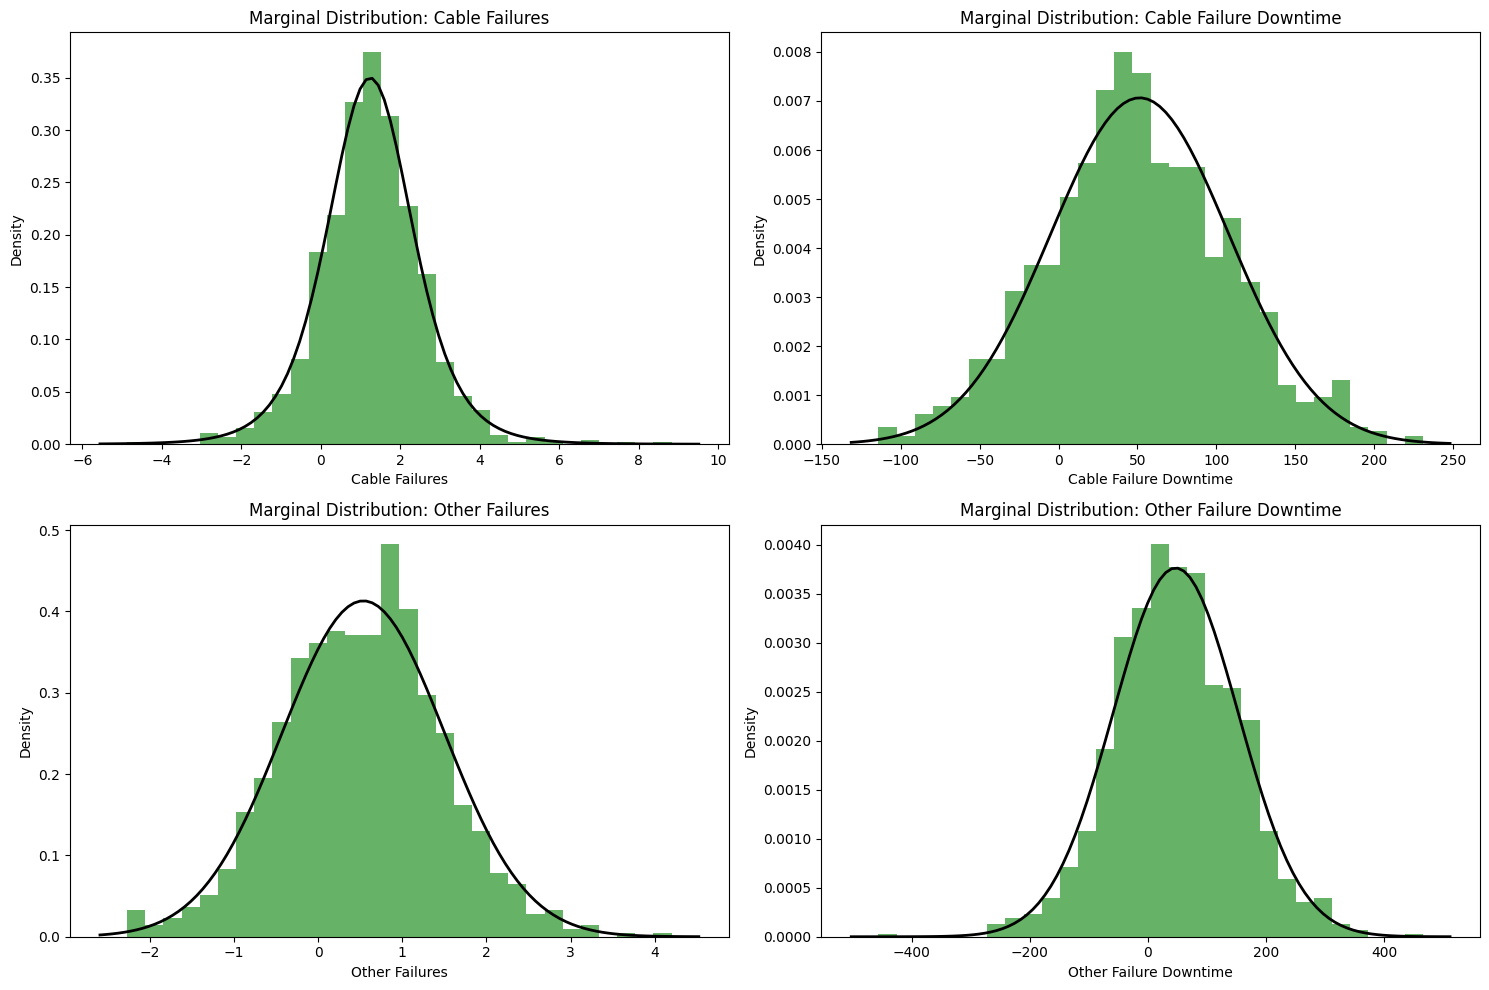

In [10]:


# Define the best-fitting distributions with their parameters
distributions = {
    'Cable Failures': stats.t(df=5.933086825232146, loc=1.2401676115413347, scale=1.0934754500282642),
    'Cable Failure Downtime': stats.norm(loc=51.442953020134226, scale=56.46848411868538),
    'Other Failures': stats.norm(loc=0.5369127516778524, scale=0.9660233988640395),
    'Other Failure Downtime': stats.norm(loc=47.04697986577181, scale=106.03914280262279)
}

# Generate samples from the distributions for visualization
num_samples = 1000
samples = {var: dist.rvs(size=num_samples) for var, dist in distributions.items()}

# Plot the marginal distributions
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, (var, sample) in enumerate(samples.items()):
    ax = axs[i//2, i%2]
    ax.hist(sample, bins=30, density=True, alpha=0.6, color='g')
    
    # Plot the PDF of the fitted distribution
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    ax.plot(x, distributions[var].pdf(x), 'k', linewidth=2)
    ax.set_title(f'Marginal Distribution: {var}')
    ax.set_ylabel('Density')
    ax.set_xlabel(var)

plt.tight_layout()
plt.show()


### 5. Modeling Dependencies with Copulas ###

We'll use the copulas library to fit a Gaussian copula model to the data.  
1. Fit a Copula: Choose and fit a copula model to your marginal CDFs.
    
2. Estimate Parameters: Extract and examine the copula parameters (e.g., covariance matrix for Gaussian,θ for Clayton).
                                                                   
3. Generate Joint Samples:3 Use the fitted copula to generate joint samples, which model the joint distribution of your original variables.

In [11]:
import numpy as np
import pandas as pd
from copulae import ClaytonCopula, GumbelCopula, StudentCopula, TCopula, GaussianCopula
from scipy.stats import t, norm
import warnings

# Drop any rows with missing values
data_clean = data.dropna()

# Convert to numpy arrays
cable_failures = np.array(data_clean['Cable Failures'])
cable_failure_downtime = np.array(data_clean['Cable Failure Downtime'])
other_failures = np.array(data_clean['Other Failures'])
other_failure_downtime = np.array(data_clean['Other Failure Downtime'])

# Define marginal CDF functions
def cable_failures_cdf(x):
    return t.cdf(x, df=5.933086825232146, loc=1.2401676115413347, scale=1.0934754500282642)

def cable_failure_downtime_cdf(x):
    return norm.cdf(x, loc=51.442953020134226, scale=56.46848411868538)

def other_failures_cdf(x):
    return norm.cdf(x, loc=0.5369127516778524, scale=0.9660233988640395)

def other_failure_downtime_cdf(x):
    return norm.cdf(x, loc=47.04697986577181, scale=106.03914280262279)

# Transform data to uniform [0, 1] scale
u1 = cable_failures_cdf(cable_failures)
u2 = cable_failure_downtime_cdf(cable_failure_downtime)
u3 = other_failures_cdf(other_failures)
u4 = other_failure_downtime_cdf(other_failure_downtime)

# Combine uniform marginals into a single dataset
data_transformed = np.column_stack([u1, u2, u3, u4])

# Define and fit copulas
copulas = {
    'Clayton': ClaytonCopula(dim=4),
    'Gumbel': GumbelCopula(dim=4),
    'Student': StudentCopula(dim=4),
    'T': TCopula(dim=4),
    'Gaussian': GaussianCopula(dim=4)
}

results = {}

# Suppress specific warnings
warnings.filterwarnings("ignore", message="For the Gumbel copula, tau must be >= 0.")

for name, copula in copulas.items():
    try:
        copula.fit(data_transformed)
        results[name] = {
            'Parameters': copula.params
        }
    except Exception as e:
        results[name] = {
            'Error': str(e)
        }

# Print the results
print("Fit results for each copula:")
for name, metrics in results.items():
    if 'Error' in metrics:
        print(f"\n{name} Copula:")
        print(f"Error: {metrics['Error']}")
    else:
        print(f"\n{name} Copula:")
        print(f"Parameters: {metrics['Parameters']}")


Fit results for each copula:

Clayton Copula:
Parameters: 0.6858769059440835

Gumbel Copula:
Parameters: 1.0757434138654727

Student Copula:
Parameters: StudentParams(df=4.462481301317624, rho=array([ 0.89015373, -0.56842323, -0.56504731, -0.55632877, -0.54379614,
        0.96206105]))

T Copula:
Parameters: StudentParams(df=4.462481301317624, rho=array([ 0.89015373, -0.56842323, -0.56504731, -0.55632877, -0.54379614,
        0.96206105]))

Gaussian Copula:
Parameters: [ 0.88457946 -0.53580353 -0.53855072 -0.55044686 -0.53833422  0.93719871]


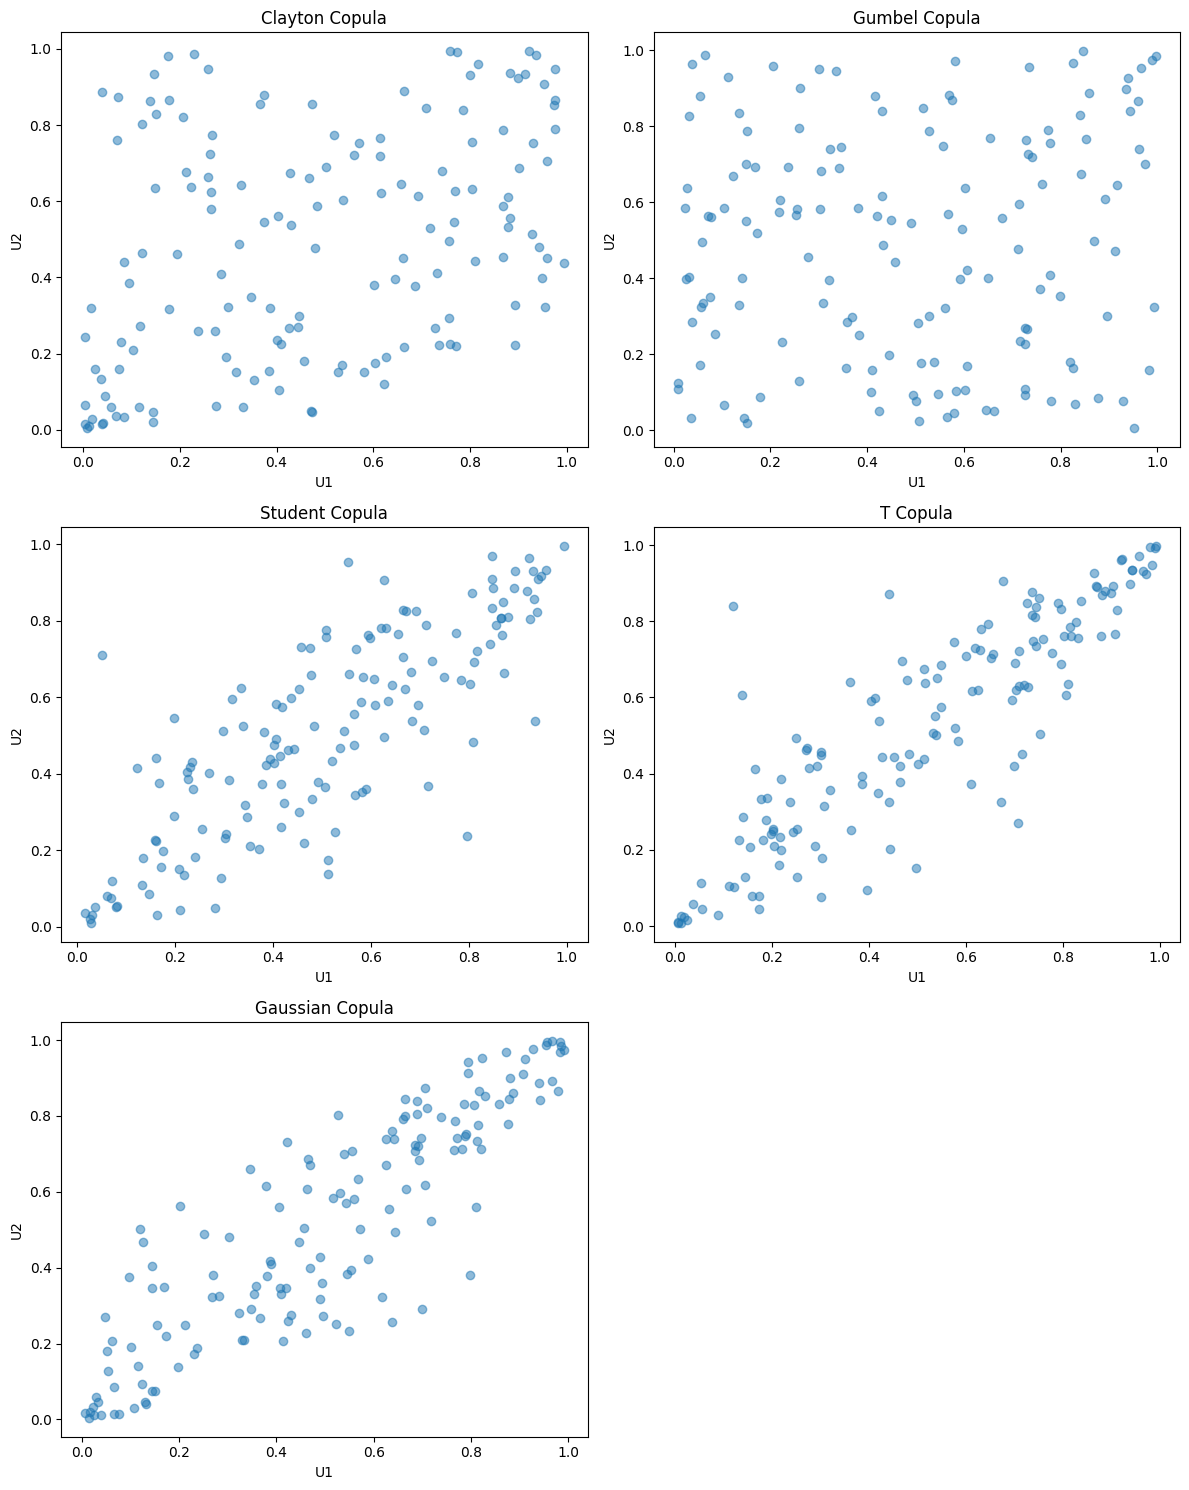

Goodness-of-fit test results for each copula:

Clayton Copula:
KS Statistic: 0.21476510067114093
P-Value: 0.0020100213343711196

Gumbel Copula:
KS Statistic: 0.2080536912751678
P-Value: 0.0030831683133777407

Student Copula:
KS Statistic: 0.2348993288590604
P-Value: 0.0005119199536829426

T Copula:
KS Statistic: 0.2483221476510067
P-Value: 0.00019164640637553916

Gaussian Copula:
KS Statistic: 0.2483221476510067
P-Value: 0.00019164640637553916

The best copula is: Gumbel


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copulae import ClaytonCopula, GumbelCopula, StudentCopula, TCopula, GaussianCopula
from scipy.stats import t, norm, ks_2samp

# Set random seed for reproducibility
np.random.seed(42)

# Drop any rows with missing values
data_clean = data.dropna()

# Convert to numpy arrays
cable_failures = np.array(data_clean['Cable Failures'])
cable_failure_downtime = np.array(data_clean['Cable Failure Downtime'])
other_failures = np.array(data_clean['Other Failures'])
other_failure_downtime = np.array(data_clean['Other Failure Downtime'])

# Define marginal CDF functions
def cable_failures_cdf(x):
    return t.cdf(x, df=5.933086825232146, loc=1.2401676115413347, scale=1.0934754500282642)

def cable_failure_downtime_cdf(x):
    return norm.cdf(x, loc=51.442953020134226, scale=56.46848411868538)

def other_failures_cdf(x):
    return norm.cdf(x, loc=0.5369127516778524, scale=0.9660233988640395)

def other_failure_downtime_cdf(x):
    return norm.cdf(x, loc=47.04697986577181, scale=106.03914280262279)

# Transform data to uniform [0, 1] scale
u1 = cable_failures_cdf(cable_failures)
u2 = cable_failure_downtime_cdf(cable_failure_downtime)
u3 = other_failures_cdf(other_failures)
u4 = other_failure_downtime_cdf(other_failure_downtime)

# Combine uniform marginals into a single dataset
data_transformed = np.column_stack([u1, u2, u3, u4])

# Define and fit copulas
copulas = {
    'Clayton': ClaytonCopula(dim=4),
    'Gumbel': GumbelCopula(dim=4),
    'Student': StudentCopula(dim=4),
    'T': TCopula(dim=4),
    'Gaussian': GaussianCopula(dim=4)
}

# Generate samples from copulas
samples = {}
for name, copula in copulas.items():
    try:
        copula.fit(data_transformed)
        samples[name] = copula.random(n=len(data_transformed))
    except Exception as e:
        print(f"Error fitting {name} copula: {e}")

# Plot scatter plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten()

for i, (name, sample) in enumerate(samples.items()):
    if i < len(axes):
        ax = axes[i]
        ax.scatter(sample[:, 0], sample[:, 1], alpha=0.5, label=name)
        ax.set_title(f'{name} Copula')
        ax.set_xlabel('U1')
        ax.set_ylabel('U2')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Goodness-of-fit using Kolmogorov-Smirnov test
def ks_test_copula(data_transformed, sample):
    d, p_value = ks_2samp(data_transformed[:, 0], sample[:, 0])
    return d, p_value

results = {}
for name, sample in samples.items():
    d, p_value = ks_test_copula(data_transformed, sample)
    results[name] = {
        'KS Statistic': d,
        'P-Value': p_value
    }

# Print the results
print("Goodness-of-fit test results for each copula:")
for name, metrics in results.items():
    print(f"\n{name} Copula:")
    print(f"KS Statistic: {metrics['KS Statistic']}")
    print(f"P-Value: {metrics['P-Value']}")

# Determine the best copula
best_copula = min(results, key=lambda name: (results[name]['KS Statistic'], -results[name]['P-Value']))

print(f"\nThe best copula is: {best_copula}")


### Interpretations : 
 So the best fitted copula is ***Gumbel Copula***
 
 Gumbel Copula Parameter: 𝜃=1.0757

Interpretation:  Gumbel Copula: The parameter 𝜃 ≈ 1.076 indicates moderate upper tail dependence. The warning suggests that some calculations might have resulted in negative tau values, which are corrected to zero. This implies the fit for upper tail dependence was adjusted for better results.

### 6. Developing Copula-Based Control Charts
When implementing multivariate control charts based on copulas, there are several methods you can use to monitor the joint behavior of multiple variables. There are various ways to plot the control chart based on fitted copula. Here are some ways : 

***1. Control Chart Based on Joint Probability Density***

Method Overview : Instead of using quantiles, this method monitors the joint probability density (PDF) of the observations using the fitted copula. When the joint probability density falls below a specified threshold, the process is flagged as out-of-control.

How it works:i)Fit the copula to the data.ii)Compute the joint probability density for each observation.
iii) Set control limits based on ***thresholds (e.g., the bottom 1% of the joint density)*** to flag out-of-control points.

___Steps___:Step 1: Each variable is transformed into the uniform space using its marginal CDF.

Step 2: Fit the Gumbel copula (or another copula) to the transformed data.

Step 3: Compute the joint density for each observation using the copula’s PDF.

Step 4: Set the control limit based on the 5th percentile of the joint density values. Any point with a joint density below this threshold is considered out-of-control.

Step 5: Plot the control chart, with the joint density values on the y-axis and the observation index on the x-axis.

***2. Multivariate Cumulative Sum (CUSUM) Chart***

Method Overview:The multivariate CUSUM chart is based on monitoring cumulative sums of deviations from target values. It can be extended to the copula framework to monitor cumulative deviations from the expected copula distribution.

How it works:
i)Fit the copula and calculate the expected joint behavior.
ii)Compute cumulative sums of the differences between observed values and expected values.
iii)Set control limits for the cumulative sums.

___Steps___:i)Fit the copula to the data.ii)Calculate the cumulative sum of deviations for each observation.
iii)Set control limits based on cumulative sum behavior

__Explanation:__ Step 1: Each variable is transformed to the uniform space using its respective marginal CDF (from your earlier analysis).

Step 2: Fit the Gumbel copula (or any other copula) to the transformed data.

Step 3: The joint CDF is obtained from the copula, which represents the joint probability of the observations.

Step 4: Compute the CUSUM statistic by calculating the cumulative sum of deviations from the mean of the joint CDF.

Step 5: Plot the MCUSUM chart, where the deviations are tracked over time.

***3.Copula-Based Hotelling's T- sqaured Control Chart:***
  
Method Overview:This control chart is widely used for multivariate process monitoring. By leveraging copulas, you can first transform the data into a uniform scale and then apply Hotelling's T- sqaured method on the transformed data.

How it works:
Apply the copula to transform the data into the uniform scale.
Use Hotelling’s T- sqaured statistic to monitor the process.

__Steps__:Step 1: Fit the Gumbel copula (or any other copula) to the data.

Step 2: Transform the data using the fitted copula.

Step 3:  Hotelling’s T- sqaured  on the copula-transformed data and plot the control chart

**Note**: There are several methods to construct copula based control chart but here __Gumbel copula is fitted to our data__ hence  considering the structure of your data, Hotelling’s T-squared control chart could be a solid option for monitoring your multivariate process. This method is particularly effective for identifying shifts in the mean of a multivariate process and can be adapted to work with copula-transformed data.
Once you’ve transformed the data using the Gumbel Copula, the chart will monitor deviations from the mean for the joint behavior of the variables. This is particularly useful in quality control scenarios where you’re monitoring for shifts in the joint distribution of multiple correlated variables.
__If our focus is on detecting tail dependencies or extreme values__, which the Gumbel Copula is good at capturing, the __Multivariate Cumulative Sum (CUSUM)__ Chart or __Joint Probability Density__ Chart might also be useful. These methods emphasize the extremes and cumulative behavior, which could complement the use of Hotelling's T- squared for capturing overall shifts in the joint process.


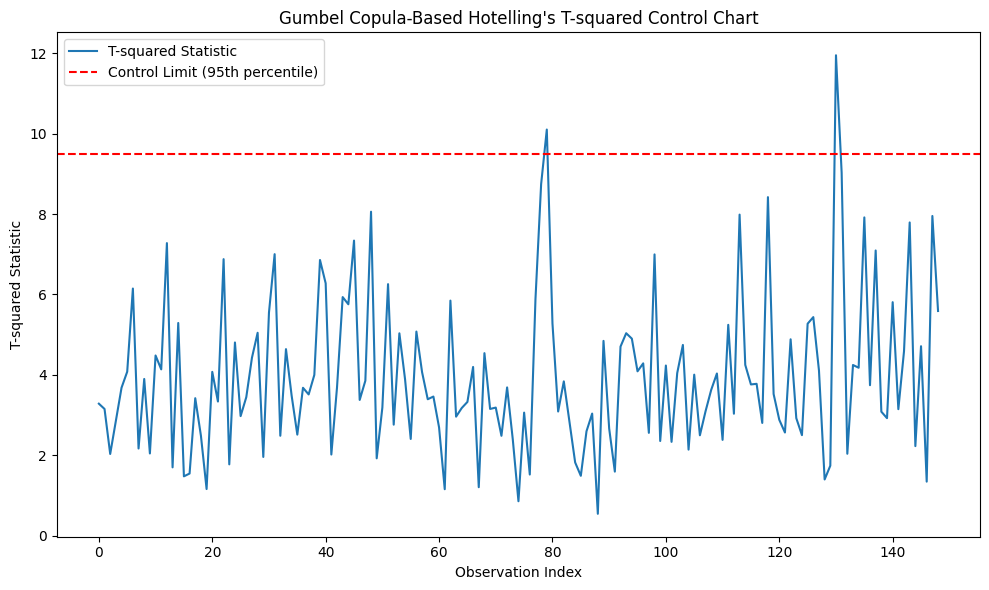

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from copulae import GumbelCopula
from scipy.stats import chi2

# Step 1: Fit the Gumbel Copula to the uniform [0,1] data
gumbel_copula = GumbelCopula(dim=4)
gumbel_copula.fit(data_transformed)

# Step 2: Transform the original data using the copula
transformed_data = gumbel_copula.random(len(data_transformed))

# Step 3: Compute Hotelling's T^2 on the copula-transformed data
mean_vector = np.mean(transformed_data, axis=0)
cov_matrix = np.cov(transformed_data, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

def hotelling_t2(data, mean_vector, inv_cov_matrix):
    diff = data - mean_vector
    t2 = np.einsum('ij,jk,ik->i', diff, inv_cov_matrix, diff)
    return t2

# Calculate Hotelling's T-squared statistics
t2_statistics = hotelling_t2(transformed_data, mean_vector, inv_cov_matrix)

# Set control limit (95th percentile of chi-squared distribution with 4 degrees of freedom)
control_limit = chi2.ppf(0.95, df=4)

# Plot Hotelling's T-squared control chart
plt.figure(figsize=(10, 6))
plt.plot(t2_statistics, label='T-squared Statistic')
plt.axhline(y=control_limit, color='r', linestyle='--', label='Control Limit (95th percentile)')
plt.title('Gumbel Copula-Based Hotelling\'s T-squared Control Chart')
plt.xlabel('Observation Index')
plt.ylabel('T-squared Statistic')
plt.legend()

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig('Gumbel Copula-Based Hotelling\'s T-squared Control Chart')
#to show the image
plt.show()

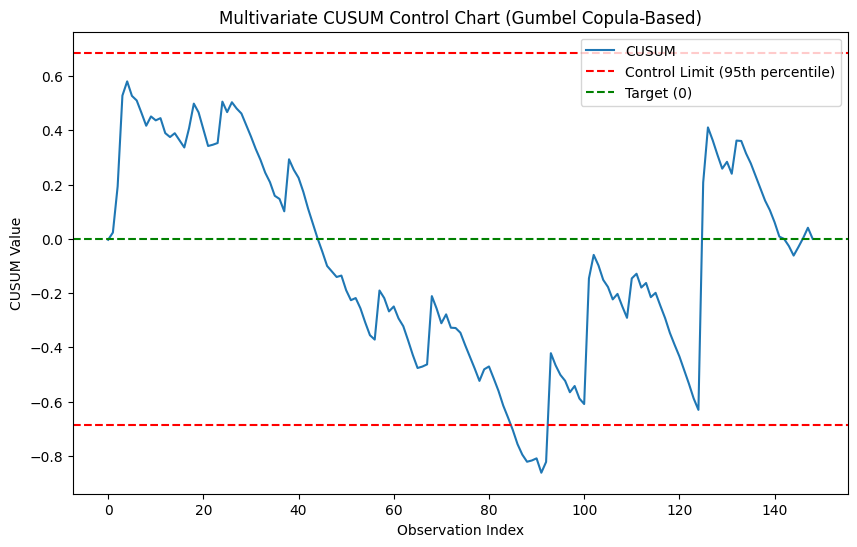

In [23]:

# Cumulative sum of deviations from copula distribution
# Step 1: Define the marginal CDFs for each variable (earlier we defined this )
# stored the data in - data_transformed

# Step 2 : Fit the Gumbel copula
gumbel_copula = GumbelCopula(dim=4)
gumbel_copula.fit(data_transformed)

# Step 3: Calculate the joint CDF from the copula
joint_cdf = gumbel_copula.cdf(data_transformed)

# Step 4: Calculate the CUSUM of deviations from the mean of joint CDF
mean_joint_cdf = np.mean(joint_cdf)
cusum = np.cumsum(joint_cdf - mean_joint_cdf)

# Step 5: Calculate control limits based on the 95th percentile of the absolute CUSUM values
control_limit = np.percentile(np.abs(cusum), 95)

# Plot the CUSUM chart
plt.figure(figsize=(10, 6))
plt.plot(cusum, label="CUSUM")
plt.axhline(y=control_limit, color='r', linestyle='--', label="Control Limit (95th percentile)")
plt.axhline(y=-control_limit, color='r', linestyle='--')  # Adding the lower control limit
plt.axhline(y=0, color='g', linestyle='--', label="Target (0)")
plt.xlabel('Observation Index')
plt.ylabel('CUSUM Value')
plt.title('Multivariate CUSUM Control Chart (Gumbel Copula-Based)')
plt.legend()
# Save the plot as a PNG image
plt.savefig('Multivariate CUSUM Control Chart (Gumbel Copula-Based)')
#to show the image
plt.show()


__Note :__ Using the absolute values of CUSUM when setting control limits is beneficial for several reasons:

Symmetry: It allows for symmetric control limits around the target, capturing deviations in either direction from the norm.

Sensitivity: This method increases sensitivity to any significant shifts, regardless of whether these shifts are above or below the target mean.

Simplification: Simplifies monitoring by using a single decision rule—if the absolute CUSUM exceeds the threshold, it signals an out-of-control condition.

This approach ensures comprehensive monitoring of all significant deviations, enhancing the effectiveness of quality control efforts.

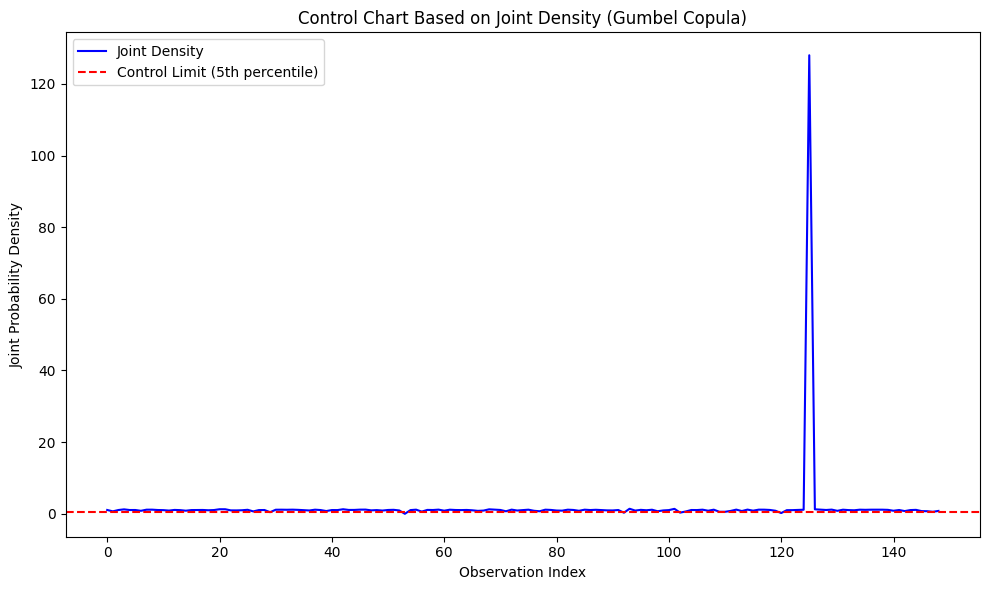

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from copulae import GumbelCopula  # Example with Gumbel copula, adjust based on your best-fitting copula
from scipy.stats import t, norm

## Step 1: Define the marginal CDFs for each variable (earlier we defined this )
# stored the data in - data_transformed

# Step 2: Fit the Gumbel copula (replace with other copulas as needed)
gumbel_copula = GumbelCopula(dim=4)
gumbel_copula.fit(data_transformed)

# Step 3: Calculate the joint density using the fitted copula's PDF
joint_density = gumbel_copula.pdf(data_transformed)

# Step 4: Set control limit using the 5th percentile of joint density
threshold = np.percentile(joint_density, 5)  # 5% threshold

# Step 5: Plot the control chart based on joint density
plt.figure(figsize=(10, 6))
plt.plot(joint_density, label="Joint Density", color='blue')
plt.axhline(y=threshold, color='r', linestyle='--', label="Control Limit (5th percentile)")
plt.xlabel('Observation Index')
plt.ylabel('Joint Probability Density')
plt.title('Control Chart Based on Joint Density (Gumbel Copula)')
plt.legend()

plt.tight_layout()
# Save the plot as a PNG image
plt.savefig('Control Chart Based on Joint Density (Gumbel Copula)')
#to show the image
plt.show()



### NOTE: 
Tail Dependency: The Gumbel copula models upper tail dependency strongly. If there are observations in your data that are extreme relative to others, the Gumbel copula's ability to emphasize these upper tail dependencies can result in a high joint density value for such points. This is especially true if these extreme observations are more aligned (i.e., they show a tendency to occur together), which is what the Gumbel copula captures.

### Traditional Control Chart (Univariate)
This chart is useful for monitoring **single-variable** processes and identifying when the process goes out of control based on the deviation from the mean. 

__Control Limits:__ The control limits are calculated as mean ± 3 * std_dev (3-sigma limits), which is a common method in control charts. 
__Out-of-Control Points:__ Points that exceed the control limits are highlighted in ***red***.

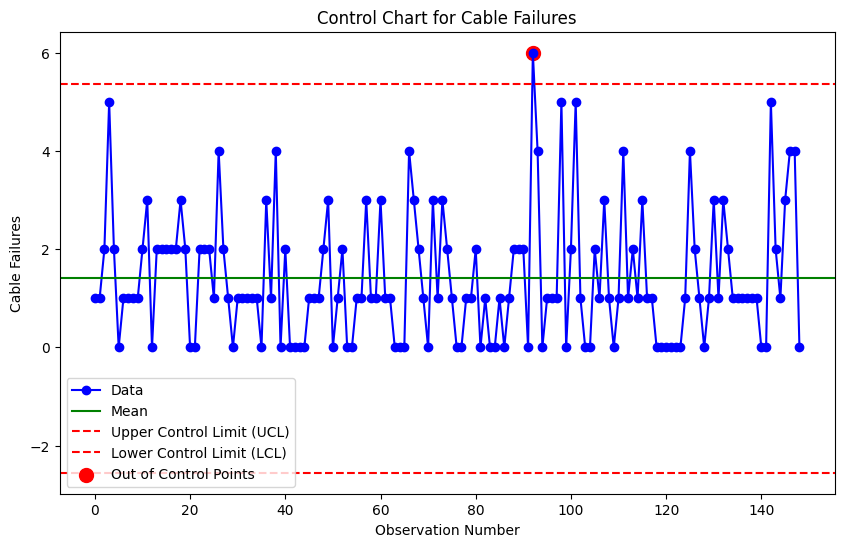

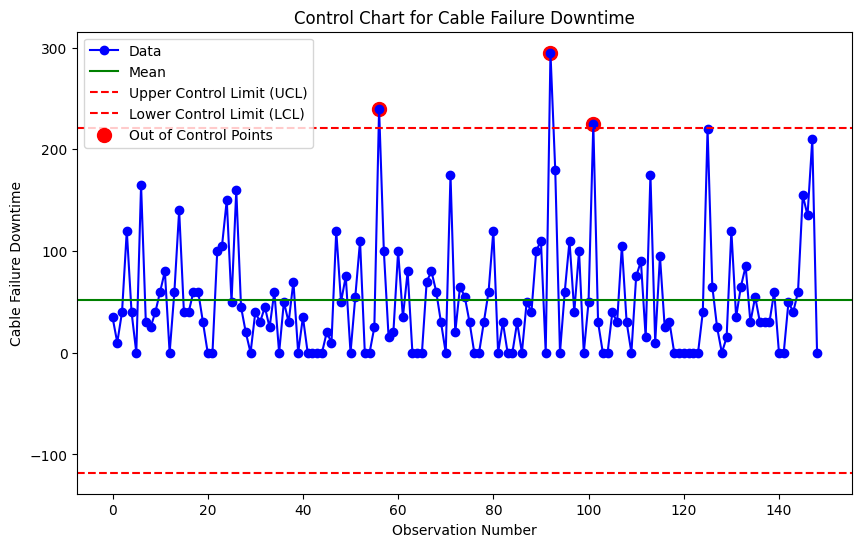

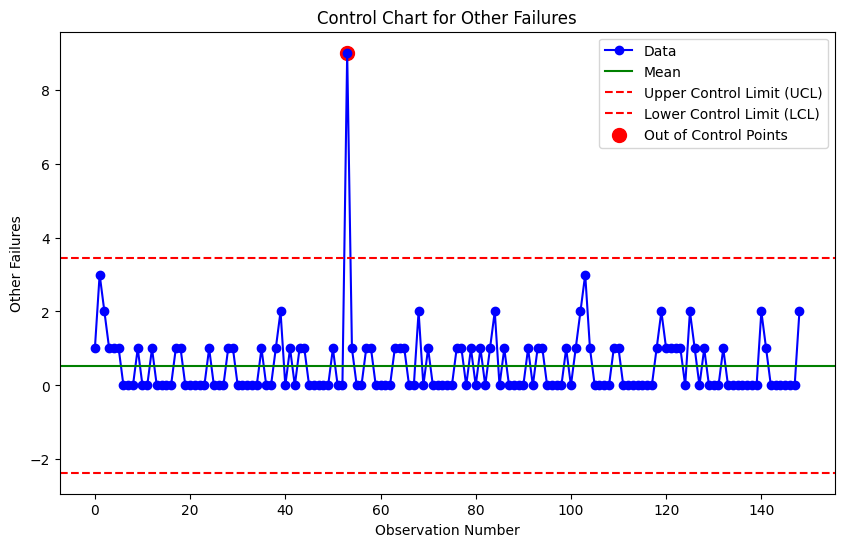

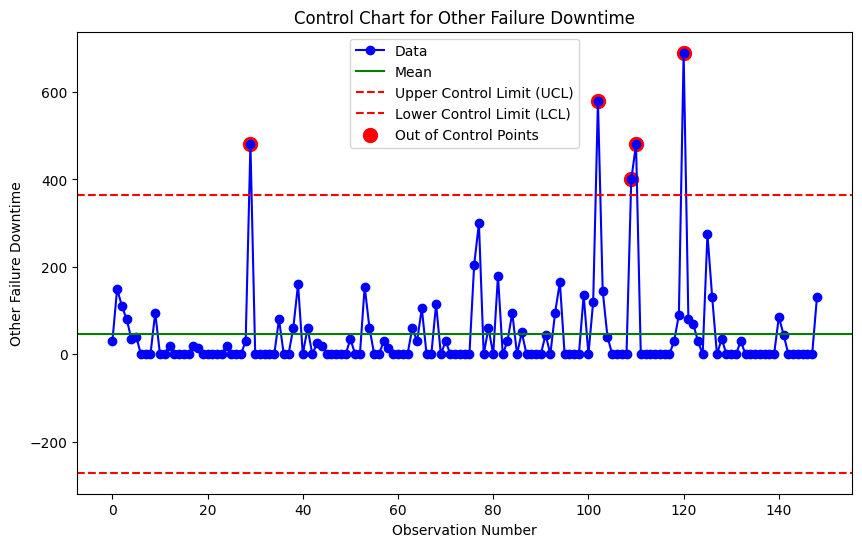

In [16]:
# Select specific columns for control charts
columns_of_interest = ['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']
data_of_interest = data[columns_of_interest].dropna()  # Make sure to drop any rows with missing values

# Plot control chart for each selected column
for column in columns_of_interest:
    data_column = data_of_interest[column]

    # Calculate the mean and standard deviation
    mean = np.mean(data_column)
    std_dev = np.std(data_column)

    # Control limits (3-sigma control limits)
    ucl = mean + 3 * std_dev  # Upper Control Limit
    lcl = mean - 3 * std_dev  # Lower Control Limit

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(data_column, marker='o', linestyle='-', color='b', label='Data')
    plt.axhline(mean, color='green', linestyle='-', label='Mean')
    plt.axhline(ucl, color='red', linestyle='--', label='Upper Control Limit (UCL)')
    plt.axhline(lcl, color='red', linestyle='--', label='Lower Control Limit (LCL)')

    # Highlight points that are out of control
    out_of_control = np.where((data_column > ucl) | (data_column < lcl))[0]
    plt.scatter(out_of_control, data_column.iloc[out_of_control], color='red', s=100, label='Out of Control Points')

    # Labels and title
    plt.xlabel('Observation Number')
    plt.ylabel(column)
    plt.title(f'Control Chart for {column}')
    plt.legend()
    plt.show()


### Traditional Control Chart (Multivariate)
__Hotelling's T-squared Control Chart:__ A multivariate extension of traditional control charts that monitors the joint behavior of multiple variables by calculating a statistic that captures shifts in the mean of the process.
__Multivariate CUSUM (MCUSUM) Control Chart:__ Tracks cumulative deviations from the process mean over time, giving more weight to recent changes and detecting small shifts.

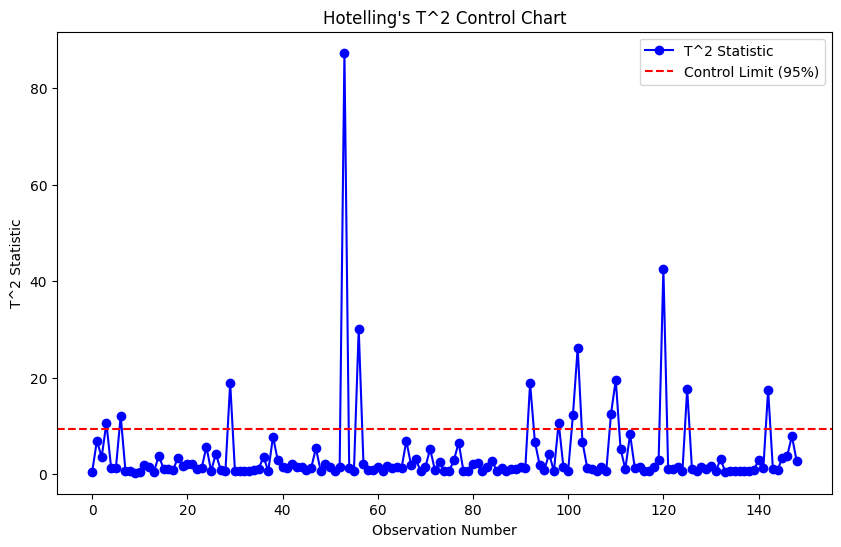

In [17]:
# Select columns of interest (Cable Failures, Cable Failure Downtime, etc.)
columns_of_interest = ['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']
data_of_interest = data[columns_of_interest].dropna()

# Compute the mean vector and covariance matrix
mu = np.mean(data_of_interest, axis=0)
cov_inv = np.linalg.inv(np.cov(data_of_interest.T))

# Calculate Hotelling's T^2 statistic for each observation
t_squared = np.array([(x - mu).T @ cov_inv @ (x - mu) for x in data_of_interest.values])

# Control limit (e.g., 95% confidence level)
n_variables = data_of_interest.shape[1]
control_limit = chi2.ppf(0.95, df=n_variables)

# Plot Hotelling's T^2 control chart
plt.figure(figsize=(10, 6))
plt.plot(t_squared, marker='o', linestyle='-', color='b', label="T^2 Statistic")
plt.axhline(y=control_limit, color='red', linestyle='--', label="Control Limit (95%)")
plt.xlabel('Observation Number')
plt.ylabel("T^2 Statistic")
plt.title("Hotelling's T^2 Control Chart")
plt.legend()
plt.show()


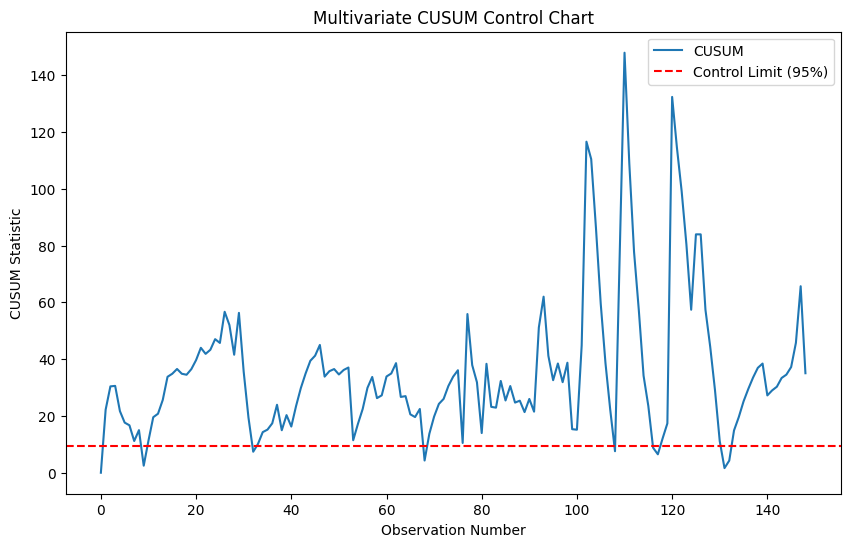

In [18]:
# Define parameters for MCUSUM
lambda_cusum = 0.2  # Smoothing factor (common range: 0.1 to 0.3)
target_vector = np.mean(data_of_interest, axis=0)  # Target value (process mean)
cusum_values = np.zeros(data_of_interest.shape)

# Initialize the first CUSUM value as 0
cusum_values[0] = np.zeros(data_of_interest.shape[1])

# Compute CUSUM for each observation
for i in range(1, len(data_of_interest)):
    deviation = data_of_interest.iloc[i].values - target_vector
    cusum_values[i] = (1 - lambda_cusum) * cusum_values[i-1] + lambda_cusum * deviation

# Plot MCUSUM chart
plt.figure(figsize=(10, 6))
plt.plot(np.linalg.norm(cusum_values, axis=1), label="CUSUM")
plt.axhline(y=chi2.ppf(0.95, df=n_variables), color='red', linestyle='--', label="Control Limit (95%)")
plt.xlabel('Observation Number')
plt.ylabel("CUSUM Statistic")
plt.title("Multivariate CUSUM Control Chart")
plt.legend()
plt.show()
